Dataset link : https://www.kaggle.com/moradnejad/200k-short-texts-for-humor-detection

Paper : https://arxiv.org/pdf/2004.12765v1.pdf

Notebook for using TPU : https://colab.research.google.com/drive/1CQMC6N6ZvbR0eB_hcEOutSlBKjNZjqOt#scrollTo=6MbwapmNIvJk

Useful Article : https://medium.com/swlh/painless-fine-tuning-of-bert-in-pytorch-b91c14912caa

In [1]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl
!pip install transformers

In [3]:
import pandas as pd
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
# import tensorflow_hub as hub
import tensorflow as tf
# import bert_tokenization as tokenization
import tensorflow.keras.backend as K
import os
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *
from sklearn.model_selection import train_test_split
import seaborn as sns
import string
import re    #for regex
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from sklearn import metrics, model_selection

In [5]:
# imports the torch_xla package
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu

In [16]:
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
# specify GPU
device = xm.xla_device()

# Dataset

In [7]:
df = pd.read_csv('/content/drive/My Drive/Jokes_Rating/dataset_colbert.csv')
df_train = pd.read_csv('/content/drive/My Drive/Jokes_Rating/train_colbert.csv')
df_test = pd.read_csv('/content/drive/My Drive/Jokes_Rating/dev_colbert.csv')
display(df_train.head(3))
display(df_test.head(3))

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True


,text,humor
0,What kind of cat should you take into the des...,True
1,Remember when people used to have to be in sha...,True
2,Pizza is always good. - everyone we'll see abo...,True


In [8]:
## As my purpose is not to perform well on this task, I will reduce the size of the test data
## Fast label encode
df = df.replace(False, 0)
df = df.replace(True, 1)
train_text, test_text, train_labels, test_labels = train_test_split(df['text'], df['humor'], 
                                                                    random_state=66, 
                                                                    test_size=0.1)
print(f"Train has {len(train_text)} samples")
print()
print(f"Test has {len(test_text)} samples")

Train has 180000 samples

Test has 20000 samples


# Tokenization

In [12]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

In [13]:
max_seq_len = 160 ## Changed from the paper, because my average jokes's length in my challenge dataset is superior to 100


# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Convert to TENSOR + Make generator

In [14]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'], dtype=torch.long)
train_mask = torch.tensor(tokens_train['attention_mask'], dtype=torch.long)
train_y = torch.tensor(train_labels.tolist(),  dtype=torch.float)

# for test set
test_seq = torch.tensor(tokens_test['input_ids'], dtype=torch.long)
test_mask = torch.tensor(tokens_test['attention_mask'], dtype=torch.long)
test_y = torch.tensor(test_labels.tolist(),  dtype=torch.float)

In [15]:
#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = torch.utils.data.distributed.DistributedSampler(
          train_data,
          num_replicas=xm.xrt_world_size(),
          rank=xm.get_ordinal(),
          shuffle=True)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, num_workers=4)

# wrap tensors
val_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
val_sampler = torch.utils.data.distributed.DistributedSampler(
          val_data,
          num_replicas=xm.xrt_world_size(),
          rank=xm.get_ordinal(),
          shuffle=True)


# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size, num_workers=4)

## Humour Classifier Architecture

In [40]:
class HumourClassifier(nn.Module):

    def __init__(self):
        super(HumourClassifier, self).__init__()
        #Instantiating BERT model object 
        self.bert_layer = DistilBertModel.from_pretrained('distilbert-base-uncased')
        
        ## Contrary to the paper, I will also do the training on Bert's last layers. In fact, I plan to use this New Bert for the joke rating on the next dataset.

        #Freeze 85% of the model architecture
        max = int(len(list(self.bert_layer.named_parameters()))*0.85) 
        i = 0
        for name, param in self.bert_layer.named_parameters():
          if i >= max:
            break
          else:
            param.requires_grad = False
            i += 1
        
        # They added two layers on the paper and dropout 0.2
        self.bert_drop = nn.Dropout(0.2)
        self.linear_layer = nn.Linear(768, 10)
        self.cls_layer = nn.Linear(10, 1)

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        cont_reps = self.bert_layer(seq, attention_mask = attn_masks)[0]

        #Obtaining the representation of [CLS] head
        cls_rep = cont_reps[:, 0]

        x = self.bert_drop(cls_rep)

        x = self.linear_layer(x)   

        #Feeding cls_rep to the classifier layer
        logits = self.cls_layer(x)

        return logits

In [41]:
model = HumourClassifier()
model = model.to(device)

# Some Functions

In [12]:
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))

def train_loop_fn(data_loader, model, optimizer, device, scheduler=None):
    model.train()

    total_loss = 0

    for bi, d in enumerate(data_loader):
        ids = d[0]
        mask = d[1]
        targets = d[2]

        ids = ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(
            ids,
            mask
        )

        loss = loss_fn(outputs, targets)

        total_loss += loss

        if bi % 100 == 0:
            xm.master_print(f'bi={bi}, loss={loss}')

        loss.backward()
        xm.optimizer_step(optimizer)
        if scheduler is not None:
            scheduler.step()

def eval_loop_fn(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    for bi, d in enumerate(data_loader):
        ids = d[0]
        mask = d[1]
        targets = d[2]

        ids = ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)

        outputs = model(
            ids,
            mask
        )

        targets_np = targets.cpu().detach().numpy().tolist()
        outputs_np = outputs.cpu().detach().numpy().tolist()
        fin_targets.extend(targets_np)
        fin_outputs.extend(outputs_np)    

    return fin_outputs, fin_targets

In [34]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

TRAIN_BATCH_SIZE = 32
EPOCHS = 5
    
lr = 1.5 * 1e-4 * xm.xrt_world_size()  ## As suggested in the paper
num_train_steps = int(len(train_data) / TRAIN_BATCH_SIZE / xm.xrt_world_size() * EPOCHS)
xm.master_print(f'num_train_steps = {num_train_steps}, world_size={xm.xrt_world_size()}')

num_train_steps = 28125, world_size=1


In [35]:
optimizer = AdamW(optimizer_grouped_parameters, lr=lr)
scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )

In [44]:
# model.load_state_dict(torch.load("/content/drive/My Drive/Jokes_Rating/Humour_Classification_epoch_0_auc_0.998.pt")) Checkpoint
# EPOCHS = 3

In [47]:
def run(rank, flags):
  torch.set_default_tensor_type('torch.FloatTensor')
  for epoch in range(EPOCHS):
    para_loader = pl.ParallelLoader(train_dataloader, [device])
    train_loop_fn(para_loader.per_device_loader(device), model, optimizer, device, scheduler=scheduler)

    para_loader = pl.ParallelLoader(val_dataloader, [device])
    o, t = eval_loop_fn(para_loader.per_device_loader(device), model, device)
    auc = metrics.roc_auc_score(np.array(t) >= 0.5, o)
    xm.save(model.state_dict(), f"/content/drive/My Drive/Jokes_Rating/Humour_Classification_epoch_{epoch +1}_auc_{auc}.bin")
    xm.master_print(f'AUC = {auc}')

In [48]:
FLAGS={}
xmp.spawn(run, args=(FLAGS,), nprocs=1, start_method='fork')

bi=0, loss=0.002072438830509782
bi=100, loss=0.005781322717666626
bi=200, loss=0.4276447892189026
bi=300, loss=0.001287437858991325
bi=400, loss=0.011800394393503666
bi=500, loss=0.23034913837909698
bi=600, loss=0.044294197112321854
bi=700, loss=0.008024115115404129
bi=800, loss=0.0517905093729496
bi=900, loss=0.006409543100744486
bi=1000, loss=0.022795623168349266
bi=1100, loss=0.07650423794984818
bi=1200, loss=0.17804096639156342
bi=1300, loss=0.006238920148462057
bi=1400, loss=0.0064539494924247265
bi=1500, loss=0.0026730226818472147
bi=1600, loss=0.010755219496786594
bi=1700, loss=0.11692599207162857
bi=1800, loss=0.0026763842906802893
bi=1900, loss=0.042239367961883545
bi=2000, loss=0.35177427530288696
bi=2100, loss=0.0011146601755172014
bi=2200, loss=0.0045997705310583115
bi=2300, loss=0.0022673241328448057
bi=2400, loss=0.03510596603155136
bi=2500, loss=0.004380350932478905
bi=2600, loss=0.00320522696711123
bi=2700, loss=0.0017995457164943218
bi=2800, loss=0.022982880473136902
b

Only one epoch was enough to achieve the best AUC

In [78]:
pred, true = eval_loop_fn(val_dataloader, model, device)

In [85]:
fpr, tpr, thresholds = metrics.roc_curve(true, pred)

In [86]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

,fpr,tpr,1-fpr,tf,thresholds
306,0.017178,0.982778,0.982822,-0.000045,-1.077182


In [ ]:
thresh = -1.077182  # I don't get it why I have those kind of value and not probability ... ## Okay My bad I forgot to use softmax or sigmoid after the last layer .........
pred_ = np.array(pred_)
true_ = np.array(true)
pred_[pred_>=thresh] = 1
pred_[pred_<thresh] = 0

Classification Report:
              precision    recall  f1-score   support

           1     0.9828    0.9828    0.9828      9987
           0     0.9828    0.9828    0.9828     10013

    accuracy                         0.9828     20000
   macro avg     0.9828    0.9828    0.9828     20000
weighted avg     0.9828    0.9828    0.9828     20000



[Text(0, 0.5, 'Not Funny'), Text(0, 1.5, 'Funny')]

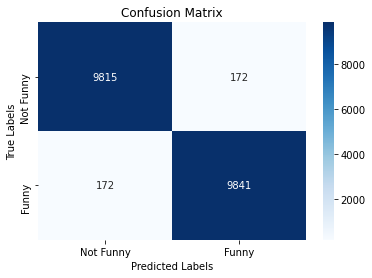

In [91]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
print('Classification Report:')
print(classification_report(true_, pred_, labels=[1,0], digits=4))
    
cm = confusion_matrix(true_, pred_, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['Not Funny', 'Funny'])
ax.yaxis.set_ticklabels(['Not Funny', 'Funny'])